<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red"> r0827764, r0819325, r0911827</span>.  
Hector Manuel Arteaga Amate

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 3(either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 

<div class="alert alert-block alert-info">
<b>NOTE:</b> The improvements/experiments made on each section are indicated through alert-block box like this one. So, you can understand the methodological process that we followed to improve! The iterations are shown in the Preprocessing section and Classifiers.
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
from PIL import Image
import random

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

from sklearn.preprocessing import MinMaxScaler 
from sklearn import decomposition
from sklearn import svm

In [2]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    '/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('/kaggle/input/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution. The method .head(N) defined in the pandas library, will allow you to check the N-first rows of the created data frame. Feel free to observe the data contained on the first 5 rows.

In [3]:
# The training set contains an identifier, name, image information and class label
train.head(1)

name  class                                                img
id                                                                      
0   Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...

In [4]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [5]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse Eisenberg is assigned the classification label 1**, and **Mila Kunis is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 HAAR face detector
In this example we use the HAAR feature based cascade classifiers to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 
OpenCV already contains many pre-trained classifiers for face, eyes, smile or even for a cat face. Those pre-trained models are stored in XML files that you can find in the [OpenCV documentation](https://github.com/opencv/opencv/tree/master/data/haarcascades).

If you want to learn more about Face detection through Haar Cascades, we recommend you to consult the next video:  
- [OpenCV Python Tutorial #8 - Face and Eye Detection](https://youtu.be/mPCZLOVTEc4)

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 1:</b></font> The initial submissions were performed with the pre-trained model "haarcascade_frontalface_default.xml" which didn't show good-enough results. Moreover, the parameters for the <b>detectMultiScale</b> were not modified.</div> 


In [6]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_alt2.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_alt2.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor = 1.05,
            minNeighbors = 9,
            minSize = (28, 28),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)
        off = 2
        return [img[y-off:y+h+off, x-off:x+w+off] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row, index, train_face):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        if train_face:
            # 48 is wrongly detected on Save and run All
            two_faces = [59, 30, 61, 48]
            if index in two_faces:
                face_to_print = faces[1]
            elif index == 70:
                face_to_print = faces[2]
            else:
                face_to_print = faces[0]
        else:
            face_to_print = faces[0]
            
        
        # only return the first face
        return cv2.resize(face_to_print, self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        if data.shape[0]<100:
            train_face = True
        else:
            train_face = False
        return np.stack([self.preprocess(row, index, train_face) for index, row in data.iterrows()]).astype(int)

### 0.3.2 MTCNN Face Detector
A second option for Face detection algorithm was performed. The MTCNN classifier (Multi-task Cascaded Convolutional Networks). The benefit over the HAAR cascade algorithm is that it allows to detect faces with various orientations and occlusions, and presenting more accuracy detecting faces. Its disadvantage is that it is slower, but speed is not that important in the current case (We will also use the graphic accelerator from kaggle when preprocessing the data). The MTCNN also detects the position of features such as eyes, nose and mouth edges, which might come in handy when training a classifier.

The first step is installing the library that we are going to use. Thereafter, the class MTCNNPreprocessor is defined. It can be observed that the algorithm is similar to the Haar detector:
1. Extract faces through a predifined method.
2. Obtain the coordinates of the rectangle where the face is located.
3. Resize the 1st face detected and append stack it into a new vector.

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 2:</b></font> The MTCNN classifier was performed. We obtained better results than Iteration 1. As it was mentioned in the previous paragraph, the computation time is the major disadvantage, even 4 times higher than Haar face extractor. We used the "Store preprocessed option" but the other collaborators didn't have acces to the information, hence, we decided to go deeper on the Multicascade face detector.</div>


In [7]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 291 kB/s            


NOTE:
The previous cell, throws a warning message which has no effect on the performance of the program. As mentioned, the MTCNN won't be used.

In [8]:
from mtcnn.mtcnn import MTCNN

class MTCNNPreprocessor():
    """Preprocessing pipeline built around MTCNN face detection"""
    
    def __init__(self, face_size):
        self.detector = MTCNN()
        self.face_size = face_size
     
    
    def extract_faces(self, img):
        """Detect the faces in the image"""
        faces = self.detector.detect_faces(img)
        result = []
        for box in faces:
            x, y, w, h = box['box']
            result.append(img[y:y+h, x:x+w]) 
        return result
    
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 3:</b></font> We decided to change the parameters on the HAARPreprocessor. First of all, we considered 3 pre-trained models: frontalface_alt, frontalface_alt2 and frontalface_alt_tree. The second one had the best performance detecting faces. After that, we started tunning the parameters of detectMultiScale method. The results were better than the iteration 2. MTCNN had 6 wrong detected faces and the updated Haar had 4.</div>  

Consult the following link to understand the meaning of each parameter, and what are the best values. 
- [Recommended values for OpenCV detectMultiScale() parameters](https://stackoverflow.com/questions/20801015/recommended-values-for-opencv-detectmultiscale-parameters)

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 4:</b></font> Multi-faces detected. One of the main problems on the training dataset were the pictures with multiple faces; how does the algorithm decide which face to show? It depends on the "minNeighbors" parameter, and on the faces detected first while the algorithm is being computed. To overcome this problem we inspected the images that were showing wrong faces, and specifically on those pictures we indicate the algorithm to show the second face detected. (It can be found on the preprocess method of the class HAARPreprocessor. Another performed change was to add a small offset on the detected coordinates of the face detected. Hence, more meaningful features of a face are covered (for example in a lot of pictures the chin cannot be observed, with the offset we obtain a more complete representation of the face. </div>  

If the training data is full of errors, outliers or noise, it will make harder for the system to detect the underlying patterns, so is less likely that our classifier will perform well. It was well worth the effort spending time on cleaning up the training data. 
According to Géron (2019), if some instances are clearly outliers or wrong data, it may help to simply discard them or try to fix the errors manually. And we opted on using the second option. Furthermore in the Mila Kunis dataset, there was an image without face, we decided to replace it for a new picture. 
[1] Géron, A. (2019) *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. O'Reilly.  

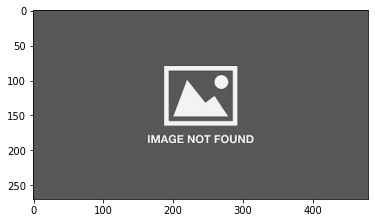

In [9]:
img_not_found = train.loc[65]["img"]
# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_not_found)

The code to replace the "Image not found" shown in the previous cell can be found on the next cell. We will let it commented, because we created a new DataSet called "Pictures", that the other collaborators had not access to, so we will perform the training with the black box. The difference in the results are not relevant.

In [10]:
# IMAGE NOT FOUND - REPLACE
# img_mila1 = cv2.imread('/kaggle/input/pictures/mila1.jpg')
# img_mila1 = cv2.cvtColor(img_mila1, cv2.COLOR_BGR2RGB)
# train.at[65,"img"] = img_mila1

# MILA KUNIS WITH GLASSES - REPLACE
# img_mila2 = cv2.imread('/kaggle/input/pictures/mila2.jpg')
# img_mila2 = cv2.cvtColor(img_mila2, cv2.COLOR_BGR2RGB)
# train.at[57,"img"] = img_mila1

# MILA KUNIS FALSE FACE DETECTED
# img_mila3 = cv2.imread('/kaggle/input/pictures/mila3.jpg')
# img_mila3 = cv2.cvtColor(img_mila3, cv2.COLOR_BGR2RGB) 
# train.at[40,"img"] = img_mila2

### 0.3.3 Visualise

A function called *plot_image_sequence* is used to print multiple images. It will be used in different parts of the code, so it was convenient to define it as a function. In the end of the next cell, each picture for both training and test set, pass through the face detector. At the moment is active the Haar Processor due to our last iteration explanation. 

In [11]:
# parameter to play with 
FACE_SIZE = (100, 100)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
# PREPROCESSED DATA
# MTCNN
# preprocessor = MTCNNPreprocessor(face_size=FACE_SIZE)
# train_X = preprocessor(train), 
# train_y, train_names = train['class'].values, train['name'].values
# test_X = preprocessor(test)

# HAARPreprocessor
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)
train_X, train_y, train_names = preprocessor(train), train['class'].values, train['name'].values
test_X = preprocessor(test)

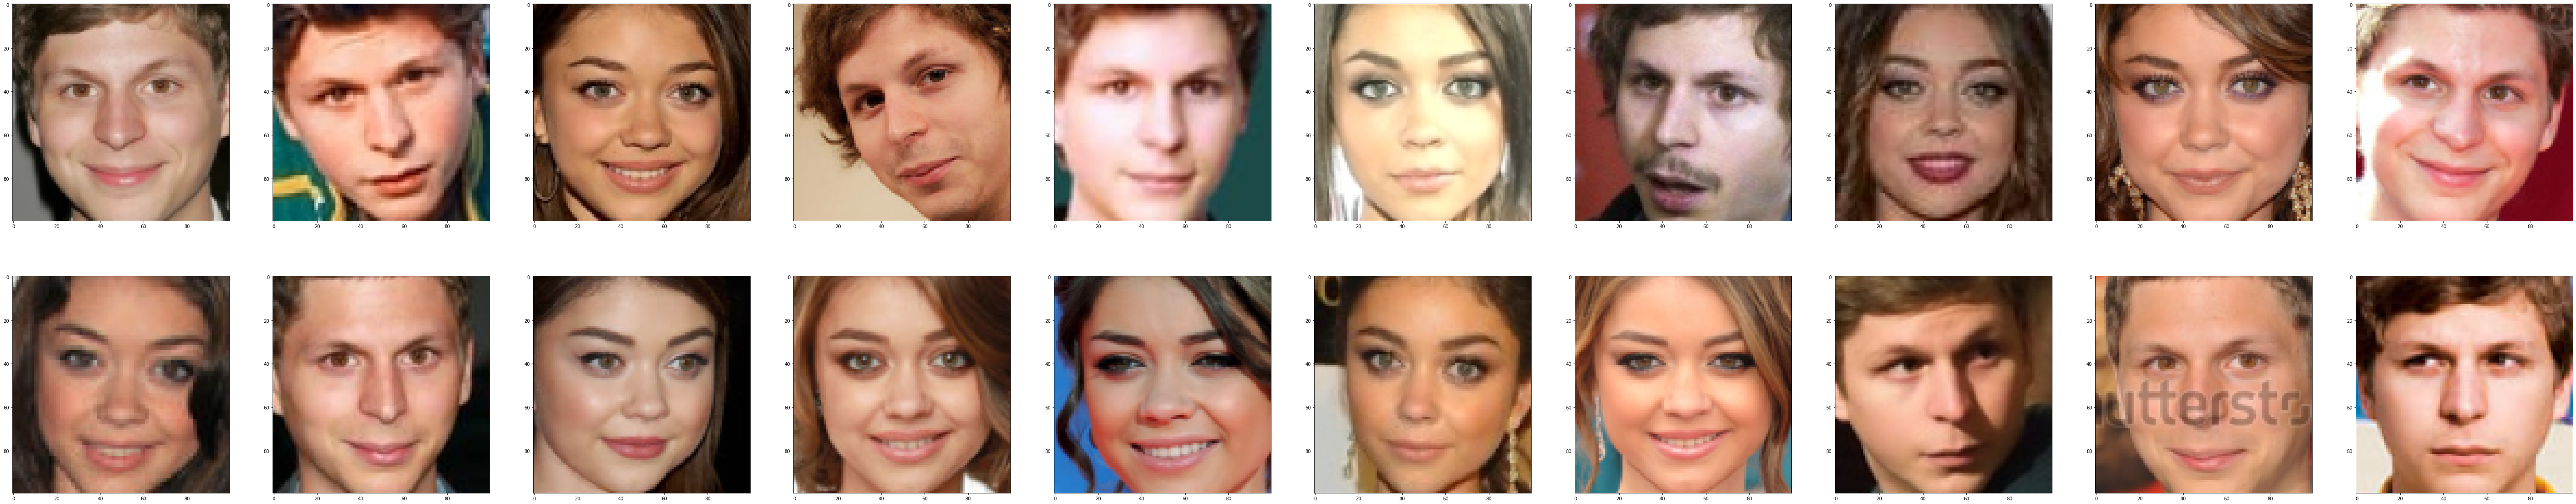

In [12]:
# Plot faces of Michael and Sarah
plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

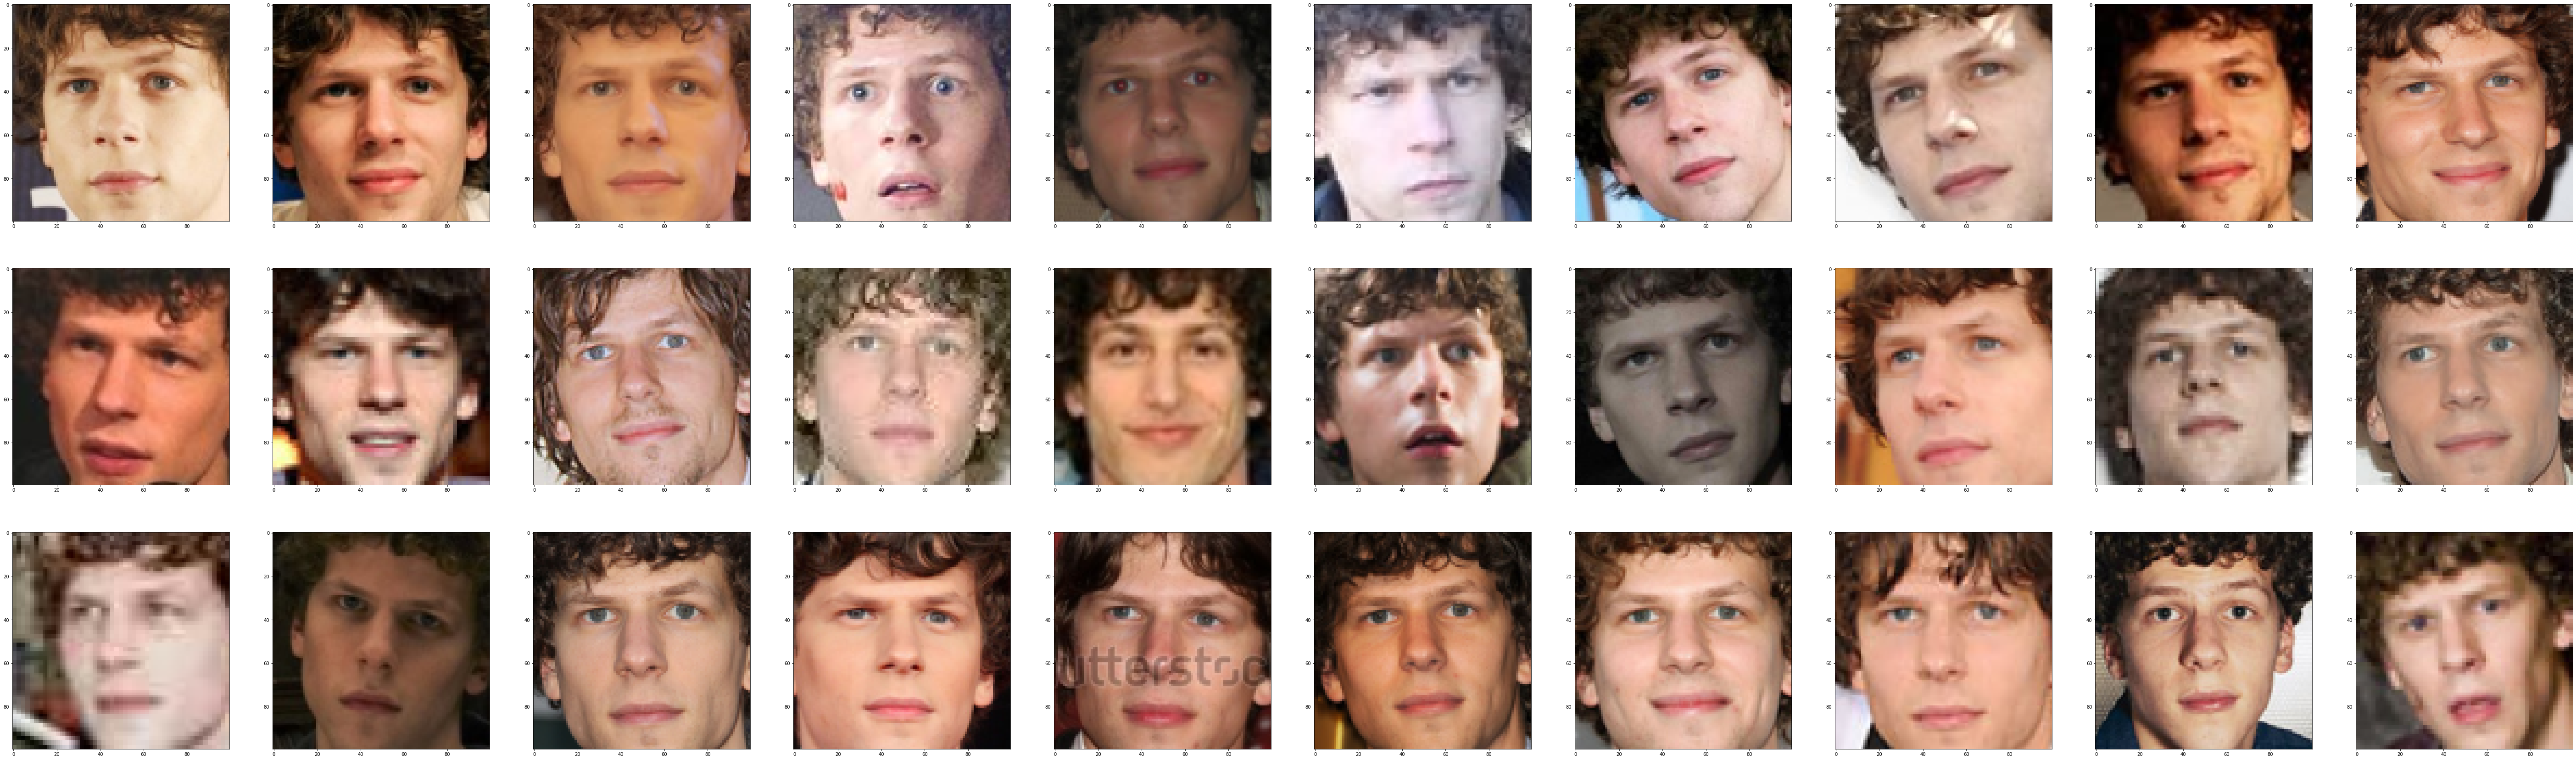

In [13]:
# Plot faces of Jesse
plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

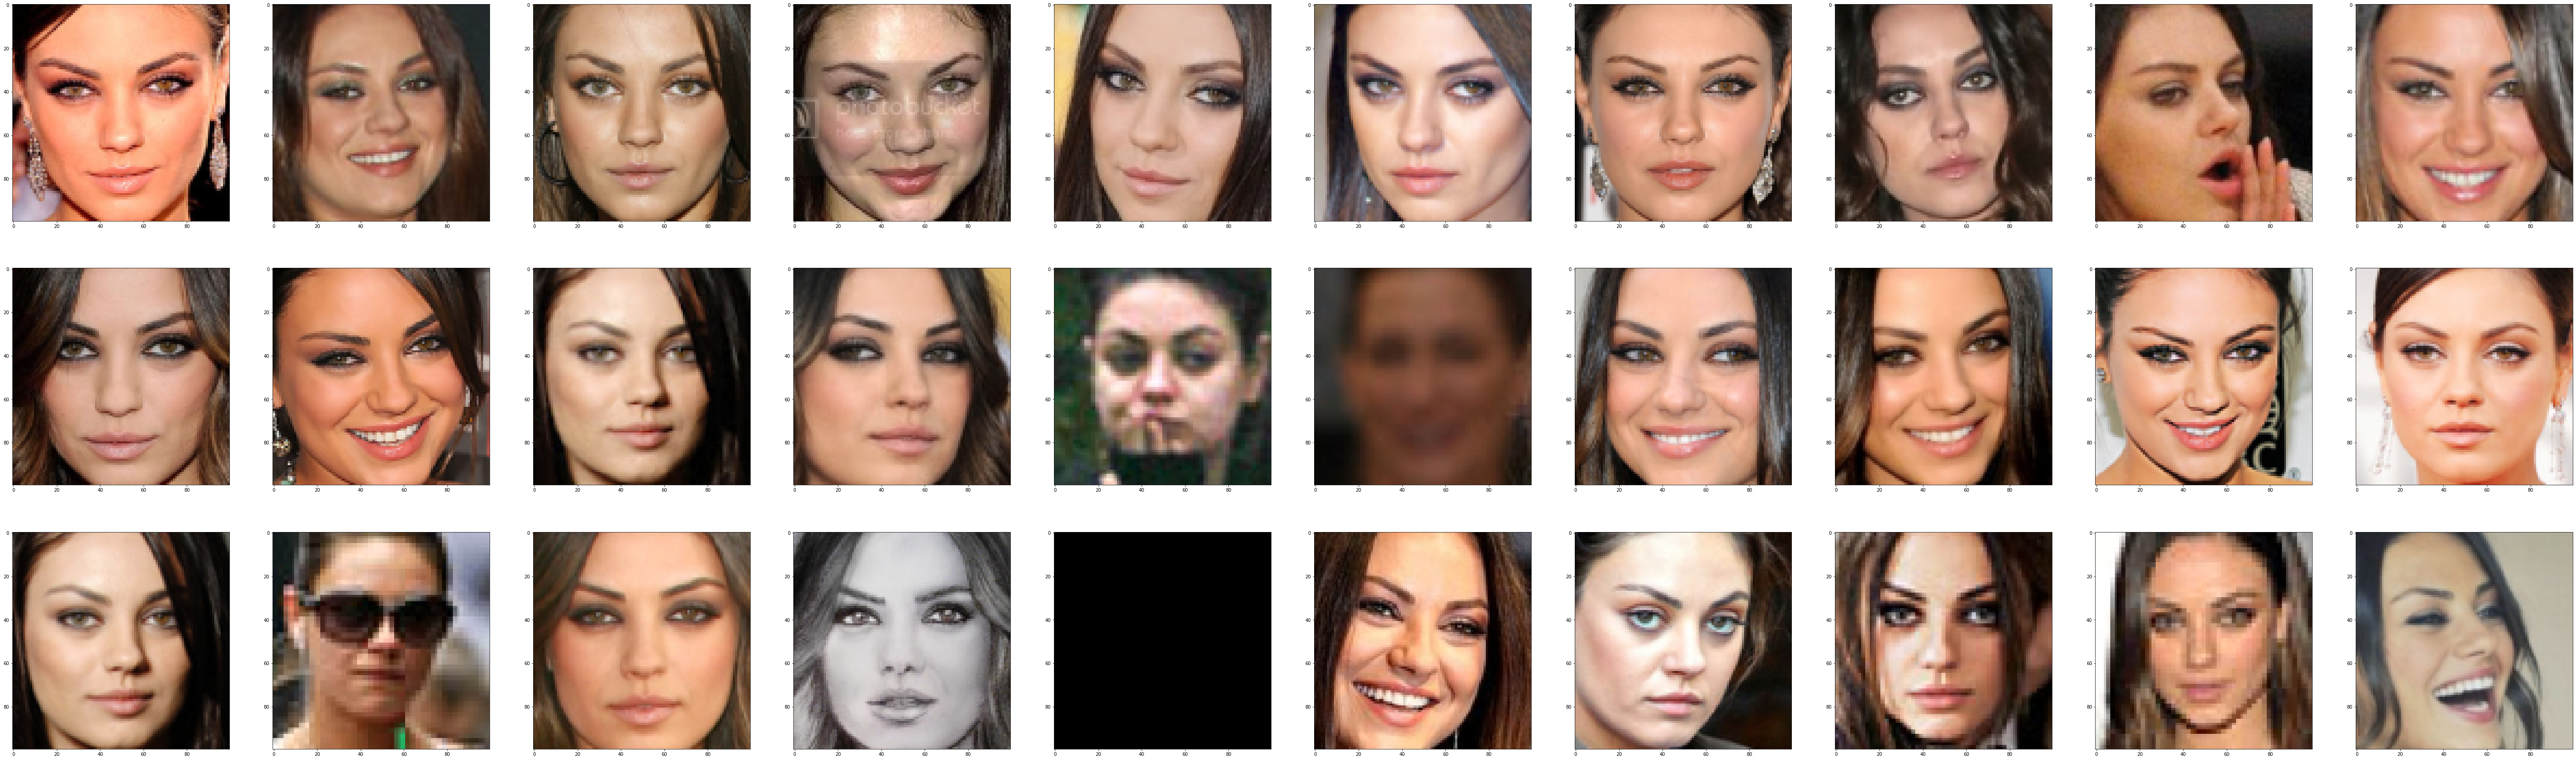

In [14]:
# Plot faces of Mila
plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 3.5:</b></font> Augmented data for the training-set. Because of the lack of pictures in our training set, we decided to try our neural network with data augmentation technique using offline augmentation: It means to perform all the necessary transformations before training the NN. The results were not better, but we thought was a good idea to try it </div>

It could happen that we don't have enough data to train a Neural Network. To get more data is not necessary to update new pictures, we just need to make minor alterations to our existing dataset. Minor changes such as flips or translations or rotations. The neural network would think these are distinct images. In the real world scenario, we may have a dataset of images taken in a limited set of conditions. But, our test dataset may exist in a variety of conditions, such as different orientation, location, scale, brightness etc. We account for these situations by training our neural network with additional **synthetically modified data**.

Take a look on the article: [Data Augmentation | How to use Deep Learning when you have Limited Data - Part 2](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range = 45, 
                         width_shift_range = 0.1,
                         height_shift_range = 0.1, 
                         shear_range = 0, 
                         zoom_range = 0.1, 
                         channel_shift_range = 30., 
                         horizontal_flip=True)

# batch_size --> (How many Images is generating)
batch_size = 5
train_X_aug = []
train_y2 =  np.empty((batch_size*train_X.shape[0],), int)

for i in range(len(train_X)):
    x = train_X[i]
    # INPUT SIZE
    # IMAGES, SIZE[0], SIZE[1], # Channels
    x = x.reshape((1, ) + x.shape)
    aug_iter = gen.flow(x, batch_size=batch_size)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(batch_size)]
    
    for j in range(batch_size):
        train_X_aug.append(aug_images[j])
        train_y2[(i*5)+j] = train_y[i]
        
train_X_aug = np.array(train_X_aug)
# TRAINING DATA = train_X_aug
# TRAINING LABEL = train_y2

## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [16]:
# SAVE PREPROCESSED DATA
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#    os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X_244.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y_244.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X_244.npy'), test_X)

# LOAD PREPROCESSED DATA
# prep_path = '/kaggle/input/face-detection/'
# if not os.path.exists(prep_path):
#    os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [17]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform

### 1.1.1. Scale Invariant Feature Transform (SIFT)

SIFT looks for local features within the image. We start with a grayscale image.

The algorithm first takes input image and makes multiple copies of it halving the resolution of the image with each copy. Each of these images starts a so-called octave. Each octave consists of the rescaled image and its gradually blurred copies. We get matrix of $N\times M$ images, where $N$ is number of octaves and $M$ is number of blur levels in each octave.

The next step is computing Differences of Gradients (DoG) from these matrices by subtracting subsequent blur levels in each octave. This gives us DoG matrix of size $N \times (M-1)$.

For DoG matrix we apply *search for local minima and maxima* to give us keypoints candidates. When we say "local" we are not only refering to the neighbors in the same image, but also pixels on corresponding positions in the neighboring blur levels in our DoG matrix.

So far we got loads of keypoints in the previous step and now we need to somehow filter those that are poorly located, that means that they are in places that are highly susceptible to noise. Low contrast keypoints and keypoints not robust to a small amount of noise must be eliminated from our selection. This is done by ussing the Taylor expansion - rejecting all points with low enough magnitude - and a Hessian matrix of second order respectively.

Now that we have filtered our set of keypoints, we need to assign each keypoint a unique "fingerprint".

For each point in our set we take a $16 \times 16$ neighborhood and calculate gradients for this small section. We divide it into 16 subsections and create a histogram of gradient values for each of those subsections. Each histogram will have 8 bins and thus this will give us 128 values for each keypoint, representing our unique "fingerprint" called descriptor.

Array of descriptors along with set of keypoint coordinates is then returned from the SIFT algorithm as an output. The descriptors may be used to match with descriptors from other image to find corresponding keypoints.

In [18]:
class SIFTFeatureExtractor(IdentityFeatureExtractor):
    #this is a draft for now - https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/
    
    def __init__(self, **params):
        # recomended value for human faces
        self.nfeatures = 45
        # recomended value
        self.nOctaveLayers = 5
        # default value
        self.contrastThreshold = 0.04
        # default value
        self.edgeThreshold = 10
        # default value
        self.sigma = 1.6
        # Only CV_32F and CV_8U are supported
        self.descriptorType = cv2.CV_32F
        #creation of the mask, to keep our descriptors in the face and not in the corners of the img
        mask = mask = np.zeros(FACE_SIZE, np.uint8)
        radius = min(FACE_SIZE) // 2 - 1
        center_x = FACE_SIZE[0] // 2 - 1
        center_y = FACE_SIZE[1] // 2 - 1

        self.mask = cv2.circle(mask, (radius, radius), radius, 255, -1)

    def transform(self, X):
        result = []
        sift = cv2.SIFT_create(nfeatures=self.nfeatures, nOctaveLayers=self.nOctaveLayers, 
                               contrastThreshold=self.contrastThreshold, edgeThreshold=self.edgeThreshold, 
                               sigma=self.sigma, descriptorType=self.descriptorType)
        for img in X:
            # in order to ease the calculation
            grey = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2GRAY)
            # computing descriptors and keypoints, applying self.mask for better feature precision
            keypoints, descriptors = sift.detectAndCompute(grey, self.mask)
            desc_unified = np.zeros((self.nfeatures, 128), np.float32)
            if type(descriptors) is type(None):
                descriptors = desc_unified
            else:
                descriptors.resize(desc_unified.shape)
            result.append(descriptors.flatten())
        return np.array(result)

### 1.1.2. Histogram of Oriented Gradients (HOG)

Histogram of Oriented Gradients is a descriptor that works by extracting the magnitude and direction of the edges. The window size is the size of the feature we are trying to extract. Since in this case we already extracted the face, the window size will be the size of the face image. The image is divided into small cells and the histogram of gradients is extracted in blocks (of multiple cells). The result is a long vector descriptor.

[1][Navneet Dalal and Bill Triggs: (2005)Histograms of Oriented Gradients for Human Detection](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)

In [19]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    #Parameters might change
    
    def __init__(self, **params):
        #Since we want to get the descriptor for an entire face, we set the win size to the size of a face
        self.win_size = FACE_SIZE
        #We chose the cell size small enough to be able to get most of the features
        self.cell_size = (25, 25)
        #We let the block size be 2 * cell_size
        self.block_size = (2 * self.cell_size[0], 2 * self.cell_size[1])
        #The stride decides the overlap between neighboring blocks 
        self.block_stride = self.cell_size
        #It is recommended to use 9 bins
        self.nbins = 18
        #False means the gradient is between 0 and 180, True means the gradient can be up to 360
        self.signed_gradients = True
        
        self.deriv_aperature = 1
        self.win_sigma = -1
        self.histogram_norm_type = 0
        self.L2_hys_threshold = 0.2
        self.gamma_correction = 1
        self.nlevels = 64
        self.params = params
        
    def transform(self, X):
        hog = cv2.HOGDescriptor(self.win_size, self.block_size, self.block_stride,
                               self.cell_size, self.nbins, self.deriv_aperature,
                               self.win_sigma, self.histogram_norm_type, self.L2_hys_threshold,
                               self.gamma_correction, self.nlevels, self.signed_gradients)
        result = []
        for image in X:
            image = image.astype(np.uint8)
            result.append(hog.compute(image))
        return np.array(result)

### 1.1.3. t-SNE Plots
t-distributed Stochastic Neighbor Embedding is a nonlinear dimensionality reduction. So it helps us separate data, which would normally be impossible to separte with a straight line. It is used to 
understand high-dimensional data by projecting it into a low-dimensional space. It was first proposed by Laurens van der Maaten and Geoffrey Hinton in 2008 [1]

[1][Laurens, M. and Geoffrey, H. (2008)Visualizing Data using t-SNE](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


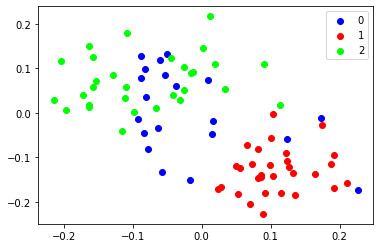

In [20]:
from sklearn.manifold import TSNE

#Get the features
hog = HOGFeatureExtractor()
hog_features = hog(train_X)
#Reduce the dimensions to the 2 most effective dimensions
tsne = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(hog_features)

tx = tsne[:,0]
ty = tsne[:,1]

#Normalize the values to the interval [0, 1]
tx = tx / (np.linalg.norm(tx))
ty = ty / (np.linalg.norm(ty))

fig = plt.figure()
ax = fig.add_subplot(111)

#Specify the colors that will be used
colors = [(0.0, 0.0, 1.0), (1.0, 0.0, 0.0), (0.0, 1.0, 0.0)]

#We have 3 classes
for c in range(3):
    indices = [i for i, y in enumerate(train_y) if y == c]
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    
    color = colors[c]
    
    ax.scatter(current_tx, current_ty, c=color, label=c)
    
ax.legend(loc='best')
plt.show()

## 1.2. Baseline 2: PCA feature extractor

### 1.2.1. Principal Component Analysis
Many Machine Learning problems involve thousands of features for each training instance. Not only does the training extremely slow, it can also make it harder to find a good solution. This problem is ofen referred to as the curse of dimensionality [Géron, 2019].  
It is possible to reduce the number of features considerably, turning it into a tractable problem; this is known as <font size="4"> **Dimensionality Reduction**.</font> Reducing dimensionality lose some information (For instance, compressing an image can degrade its quality). Although it will speed up training, it may make the system to perform slightly worse.

<font size="4"> **Principal Component Analysis (PCA)** </font>  is by far the most popular dimensionality reduction algorithm. First it identifies an hyperplane that lies the closest to the data, an then it projects the data onto it.

In order to choose the right hyperplane, it is important to select the axis that preserves the <font size="4"> **maximum amount of variance** </font>, as it will most likely lose less information than other possible projections. Computing maximum variance ensures that this axis will minimize the mean squared distance between the original dataset and its projection onto that axis.
In 2D, PCA also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance. If it were a higher-dimensional data-set, PCA would also find as many axes as the number of dimensions in the dataset. In the figure shown in the next cell, it is possible to see that over the line *c1* it is obtained the highest amount of variance, and *c2*, which is orthogonal to *c1*, keeps the remaining variance. 
The unit vector that defines the $i^{th}$ axis is called the **$\mathbf i^{th}$ Principal component (PC)**.

More information on PCA:  
[1] Géron, A. (2019) *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. O'Reilly.  
[2] [StatQuest: Principal Component Analysis (PCA), Step-by-Step](https://youtu.be/FgakZw6K1QQ)  
[3] [Principal Component Analysis - LearnOpenCV](https://learnopencv.com/principal-component-analysis/)

In [21]:
# IMAGE TO BE INSERTED AS A PART OF THE MARKDOWN
# pca_image = Image.open('/kaggle/input/pictures/PCA.PNG')
# pca_image

<font size="5"> **PCA ALGORITHM** </font>

1. **Input** a dataset of N face images (Performed in section 0)
2. **Preprocessing:** 
  - All the images have the same size.
  - Conversion RGB to Gray-Scale.
3. **Assemble** a data matrix:  
  - For each of the train set images, a single vector should be formed. The size of this vector will be $(1,K^2)$, where $K$ is the width and height of the image in pixels (assuming a square image).
  - A matrix is formed concatenating each of this image-flattened vectors. The size of the matrix will be $(N,K^2)$
4. Compute the **mean** $\mu_i$ of each colum in the matrix.
5. **Mean centering**. Subtract the $\mu_i$ from each column $c_i$. 
6. **Singular Value Decomposition**. Compute SVD over the mean centered matrix. The eigenvectors of the matrix will be sorted from highest value to lowest. Originally the PCA method asks to compute [the covariance matrix](https://www.youtube.com/watch?v=DQ_BkPHIl-g) of the mean centered data. Through SVD it is possible to do that in an inderect way. 
7. **Eigenfaces**. Each of the eigenvectors should be reshaped in the original size of each image $(K,K)$. These new images are known as the eigenfaces.

Sources:  
[1] [Scikit-learn: sklearn Decomposition PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit)  
[2] [Eigenface using OpenCV-Python - LearnOpenCV](https://learnopencv.com/eigenface-using-opencv-c-python/)

*Great part of the algorithm was obtained through inspection of the sklearn documentation.

In [22]:
class PCAFeatureExtractor(IdentityFeatureExtractor):
    
    def __init__(self, n_components, face_size, whiten=False):
        self.n_components = n_components
        self.FACE_SIZE = face_size
        self.whiten = whiten
    
    def fit(self, X):
        n_samples, n_features = X.shape

        self.mean = np.mean(X, axis=0, dtype=np.float64)
        self.mean_face = self.mean.reshape(self.FACE_SIZE)

        centered_data = X - self.mean
        # ECONCOMIC SVD
        U, S, Vt = np.linalg.svd(centered_data, full_matrices=False)
        
        # CHANGING SIGNS
        max_abs_cols = np.argmax(np.abs(U), axis=0)
        signs = np.sign(U[max_abs_cols, range(U.shape[1])])
        U *= signs
        Vt *= signs[:, np.newaxis]

        components = Vt

        explained_variance = (S ** 2) / (n_samples - 1)
        total_var = explained_variance.sum()
        explained_variance_ratio = explained_variance / total_var
        singular_values = S.copy()

        self.U_vector = U[0:self.n_components]
        self.S_vector = S[0:self.n_components]

        self.components = components[0:self.n_components]
        self.explained_variance = explained_variance[:self.n_components]
        self.explained_variance_ratio = explained_variance_ratio[:self.n_components]
        self.singular_values = singular_values[:self.n_components]

        eigenFaces = [];
        for i in range(0, self.n_components):
            eigenFace = np.reshape(self.components[i,:], self.FACE_SIZE)
            eigenFaces.append(eigenFace)
        self.eigenFaces = eigenFaces
        return U, S, Vt
    
    def transform(self, X):
        U, S, Vt = self.fit(X)

        if self.whiten:
            U = U[:, :self.n_components] * sqrt(X.shape[0] - 1)
        else:
            U = U[:, :self.n_components] * S[:self.n_components]
        # X_proj = X*V = U*S*Vt*V = U*S
        return U
        
    def inverse_transform(self, X):
        return np.dot(X, self.components) + self.mean

In order to convert the image dataset to a 2D matrix of size $(N,K^2)$, where N = 80 for the training set and N = 1816 for the test set, the next cells of code were computed: 
Process:  
1. Initialize a matrix of zeros.
2. Convert the image to gray-scale.
3. Flatten the image and append it into the initialized matrix.
4. The full matrix "x_flat" is normalized.

In [23]:
# PREPROCESSING || ASSEMBLE A DATA MATRIX (TRAIN DATA)
# Size of the array (100, 100, 3) --> 100pixels * 100pixes * 3 channels
n_components = train_X.shape[0]
size = train_X[0].shape
x_flat = np.zeros((n_components, size[0]*size[1]), dtype=np.int32)

# Transfer first to GRAY SCALE
# Function .flatten() --> Return a copy of the array collapsed into one dimension
for i in range(0, n_components):
    image = cv2.cvtColor(np.float32(train_X[i]), cv2.COLOR_RGB2GRAY).astype(int)
    x_flat[i,:] = image.flatten()

# NORMALIZING DATA
scaler = MinMaxScaler().fit(x_flat)
train_X_flat = scaler.transform(x_flat)


In [24]:
# PREPROCESSING || ASSEMBLE A DATA MATRIX (TEST DATA)
n_components_test = test_X.shape[0]
size = test_X[0].shape
test_flat = np.zeros((n_components_test, size[0]*size[1]), dtype=np.int32)

# Transfer first to GRAY SCALE
# Function .flatten() --> Return a copy of the array collapsed into one dimension
for i in range(0, n_components_test):
    image = cv2.cvtColor(np.float32(test_X[i]), cv2.COLOR_RGB2GRAY).astype(int)
    test_flat[i,:] = image.flatten()

# NORMALIZING DATA
scaler2 = MinMaxScaler().fit(test_flat)
test_X_flat = scaler2.transform(test_flat)

### 1.2.2. Eigenface Plots

1. The mean face was computed inside of the fit method of the class *PCAFeatureExtractor*. The reshape of that vector was also performed inside the previously mentioned method. After that, it is important to **subtract the mean** from each image; principal components inevitably come through the origin. If the data is not centered, the 1st principal component may cross the data cloud not along the main direction and for statistical purposes this component will be misleading.

In [25]:
# IMAGE TO BE INSERTED AS A PART OF THE MARKDOWN
#pca_image2 = Image.open('/kaggle/input/pictures/PCA_centered.png')
#pca_image2

In [26]:
# DEFINIE AN OBJECT OF PCAFeatureExtractor Type
# It will be computed with the total amount of components = 80
pca = PCAFeatureExtractor(n_components, FACE_SIZE)
pca.fit(train_X_flat);

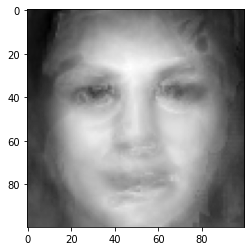

In [27]:
# PRINT MEAN FACE
plt.set_cmap(plt.cm.gray)
plt.imshow(pca.mean_face)

2. The eigenfaces are related with the matrix $\mathrm V$ computed in the fit method. The columns of $\mathrm V$ are known as the principal directions/eigenvectors. SVD computes $\mathrm V^T$, which is useful for us, in order to have every principal direction in each row. Thereafter, a reshape algorithm was performed for each eigenface.

The maximum amount of non-zero eigenvalues will be equal to the size of the sample, in this case 80.  Performing SVD, the matrix $\Sigma$ have the same shape of the input matrix $\mathrm X^{N \times K^2}$ . Moreover, $\Sigma$ is formed by a diagonal matrix on which the eigenvalues are alocated, and when $ N \leq K^2$ this matrix has at most $N$ non-zero elements.

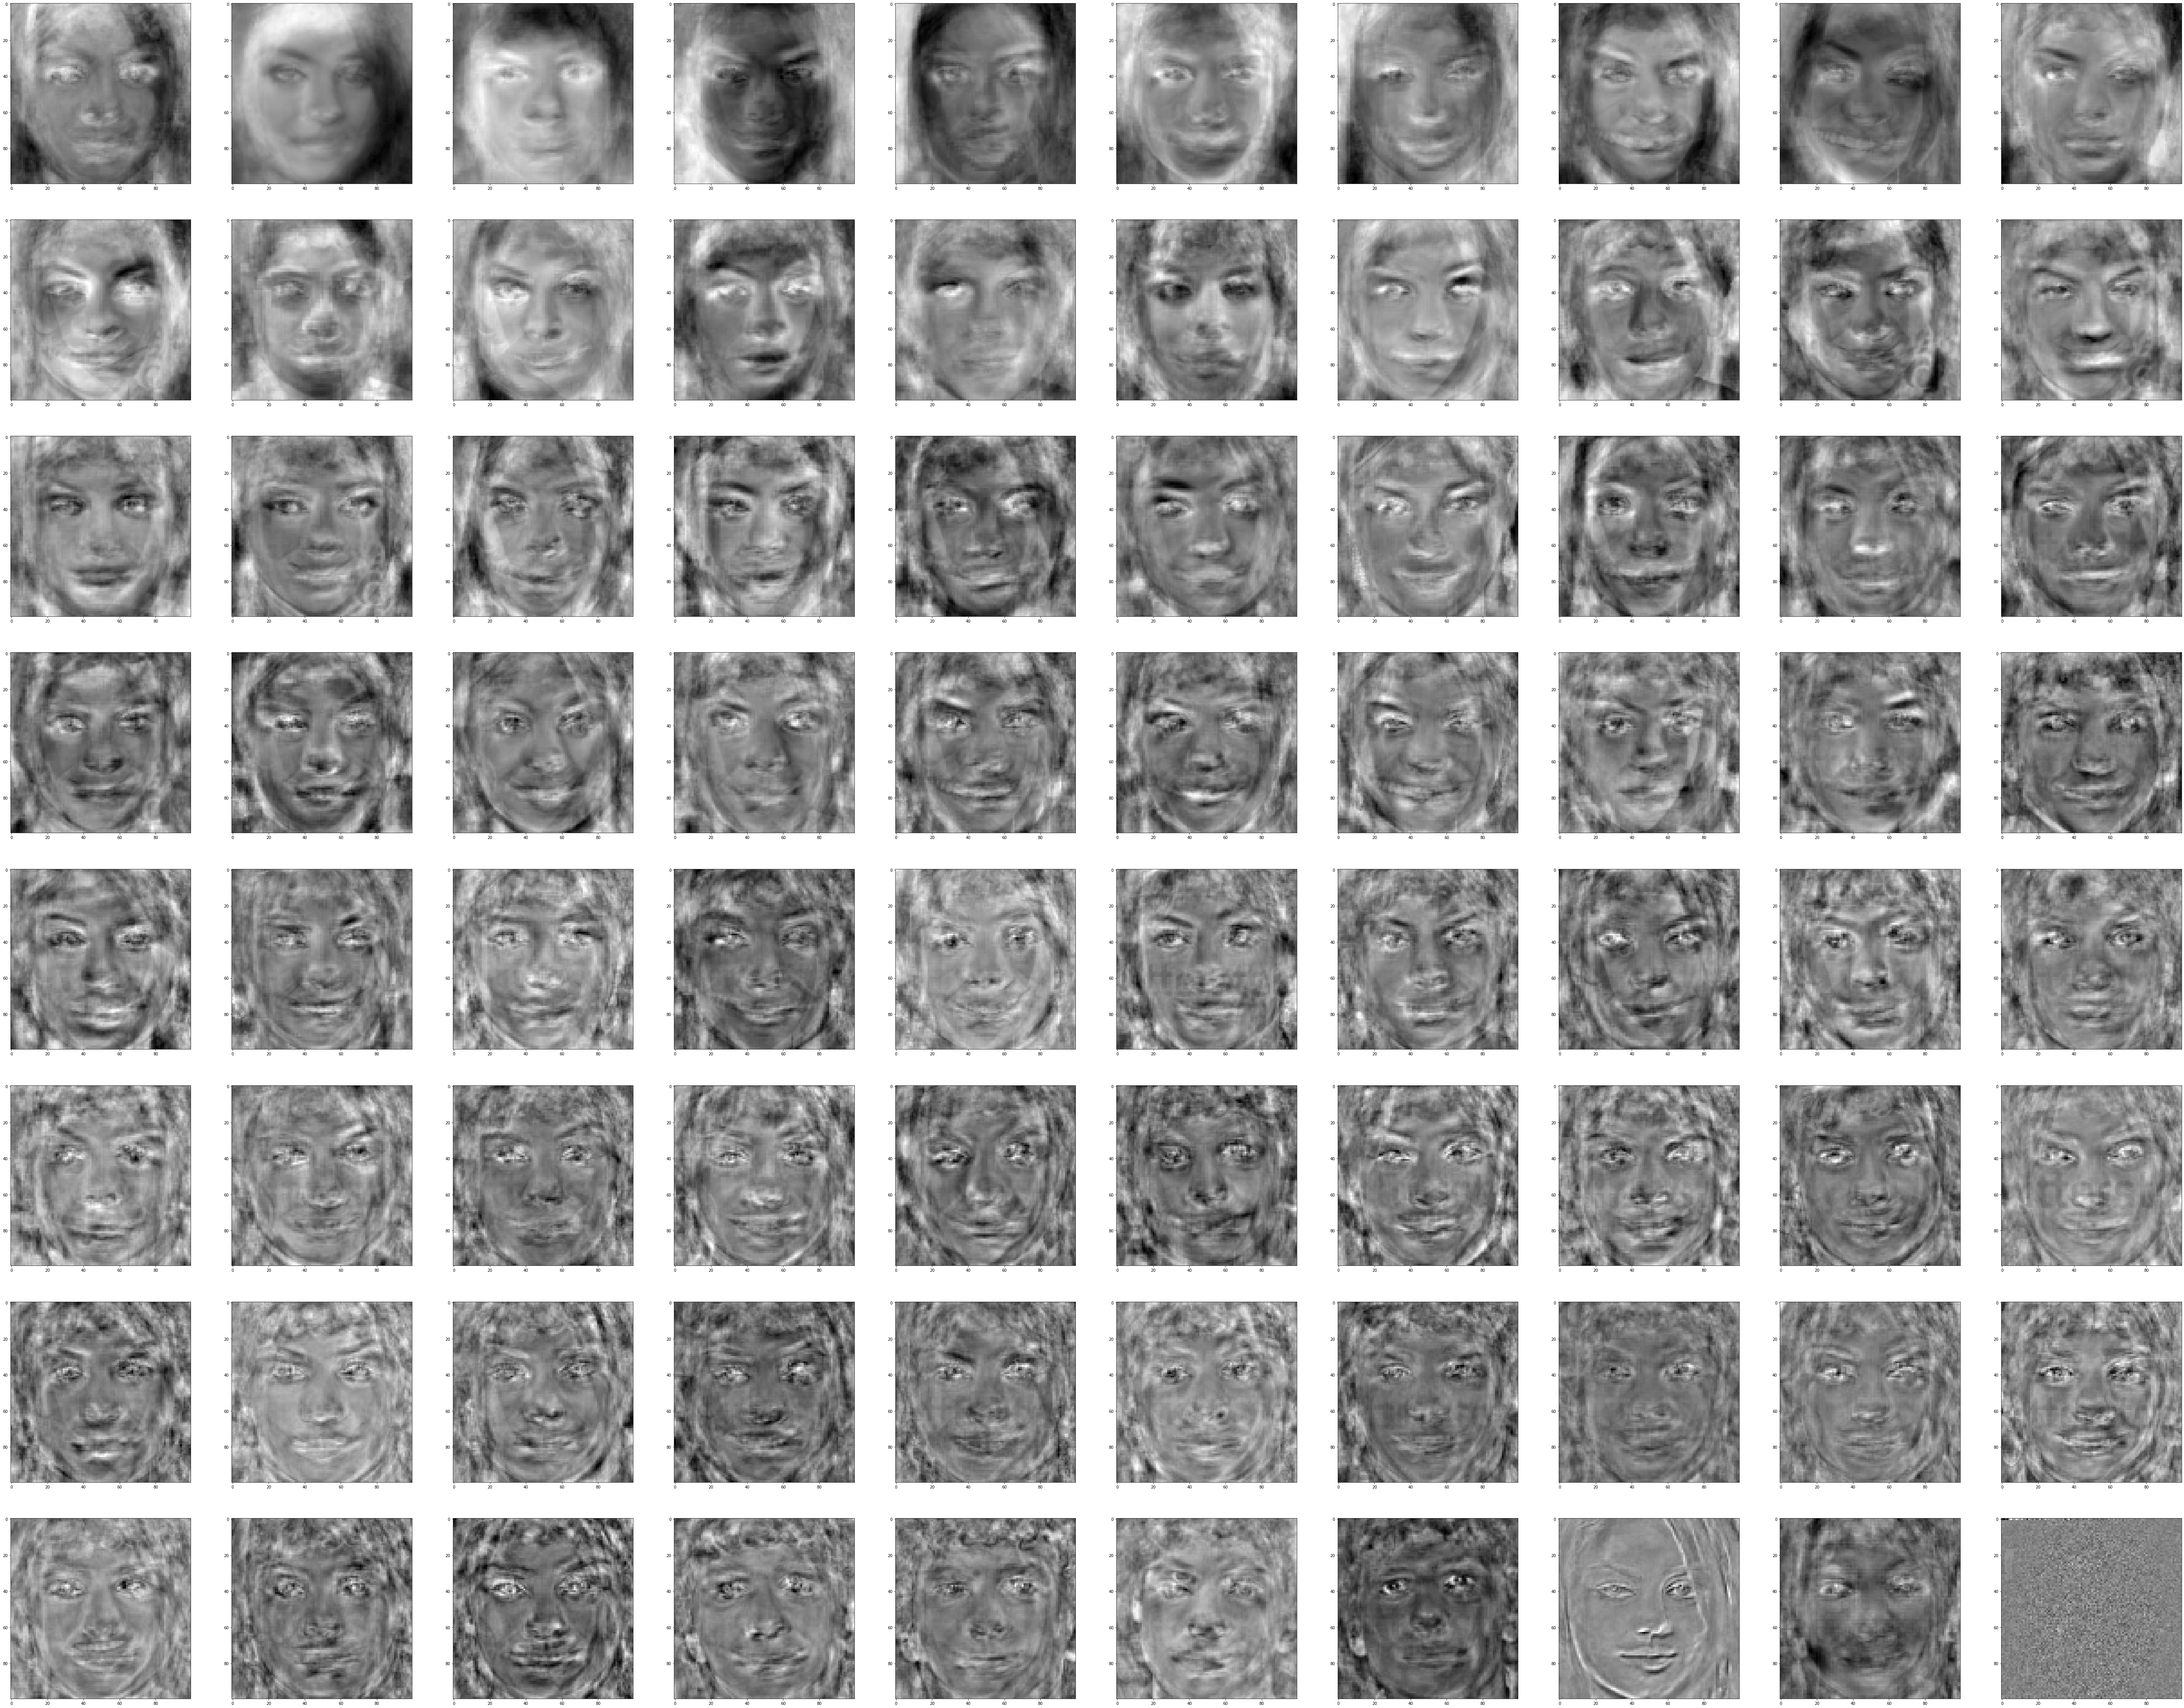

In [28]:
# PRINT EIGENFACES
plot_image_sequence(pca.eigenFaces, n=n_components, imgs_per_row=10)

### 1.2.3. Feature Space Plots

Once the principal components have been identified, it is possible to reduce the dimensionality of the dataset down to *d* dimensions by projecting the original data onto the hyperplane defined by the first *d* principal components.  
To project the training set onto the hyperplane, a matrix multiplication is computed of the training set matrix **X** by the matrix $W_d$, defined as the matrix containing the first *d* principal components (The matrix composed of the first *d* rows of **V**).  
It can be observed in the method *transform*, that the projection is not obtained using the multiplication $\mathrm {X_{proj} = XV}$, instead it computed as $\mathrm {X_{proj} = US}$.  Why? 

Let's remember that the SVD is calculated as $\mathbf {X = U\Sigma V^T}$, if both sides of the equation are multiplied by $\mathrm V$, the next equation is derived:  
$\mathrm {XV = U\Sigma V^T V} \longrightarrow \mathrm {XV = U\Sigma} $. Thus it is demonstrated that is valid to perform the last equation to compute the projection. 

<font size="4"> **Visualize the faces on the feature space using the first two principal components** </font>
1. Create a pca object, using just the first 2 principal components.
2. Project each image into the 2 principal components. 
3. Reconstruct each image applying an inverse transform and then add the mean of the pictures, which was substracted previously. 


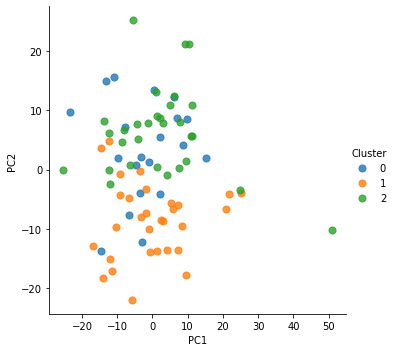

In [29]:
pca_2 = PCAFeatureExtractor(2, FACE_SIZE)
pca_2.fit(train_X_flat);

# Project --> Reconstruction 
X_projected2 = pca_2.transform(train_X_flat)
reconstructed_data = pca_2.inverse_transform(X_projected2)

reconstructed_images = [];
for i in range (len(train_X)):
    reconstructed_image = np.reshape(reconstructed_data[i],FACE_SIZE)
    reconstructed_images.append(reconstructed_image)  

# CREATE A DATA FRAME WITH THE IMAGES PROJECTED OVER THE 2 PRINCIPAL COMPONENTS
# Thereafter add the labels of the classifier in a new column. 
# Also the names, just with the purpose of make easier reading
pca_df = pd.DataFrame(data = X_projected2, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = train_y
pca_df['Names'] = train_names

# Hue --> Color by cluster
# scatter --> Specify the point size
sns.lmplot( x="PC1", y="PC2",data = pca_df, fit_reg=False, hue='Cluster', legend=True, scatter_kws={"s": 50}) 

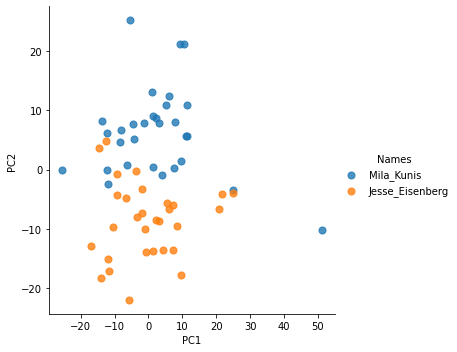

In [30]:
# PRINTING JUST THE INFORMATION OF MILA KUNIS AND JESSE EISENBERG
# WHY? --> Feel free to execute this cell to check if there is 
# any clustering which divides Jesse Eisenber and Mila Kunis
pca_jesse = pca_df[train_y == 1]
pca_mila = pca_df[train_y == 2]
pca_jesse_mila = pd.concat([pca_jesse, pca_mila])
pca_jesse_mila = pca_jesse_mila.sort_index(axis=0)
sns.lmplot( x="PC1", y="PC2",data = pca_jesse_mila, fit_reg=False, hue='Names', legend=True,scatter_kws={"s": 50}) 

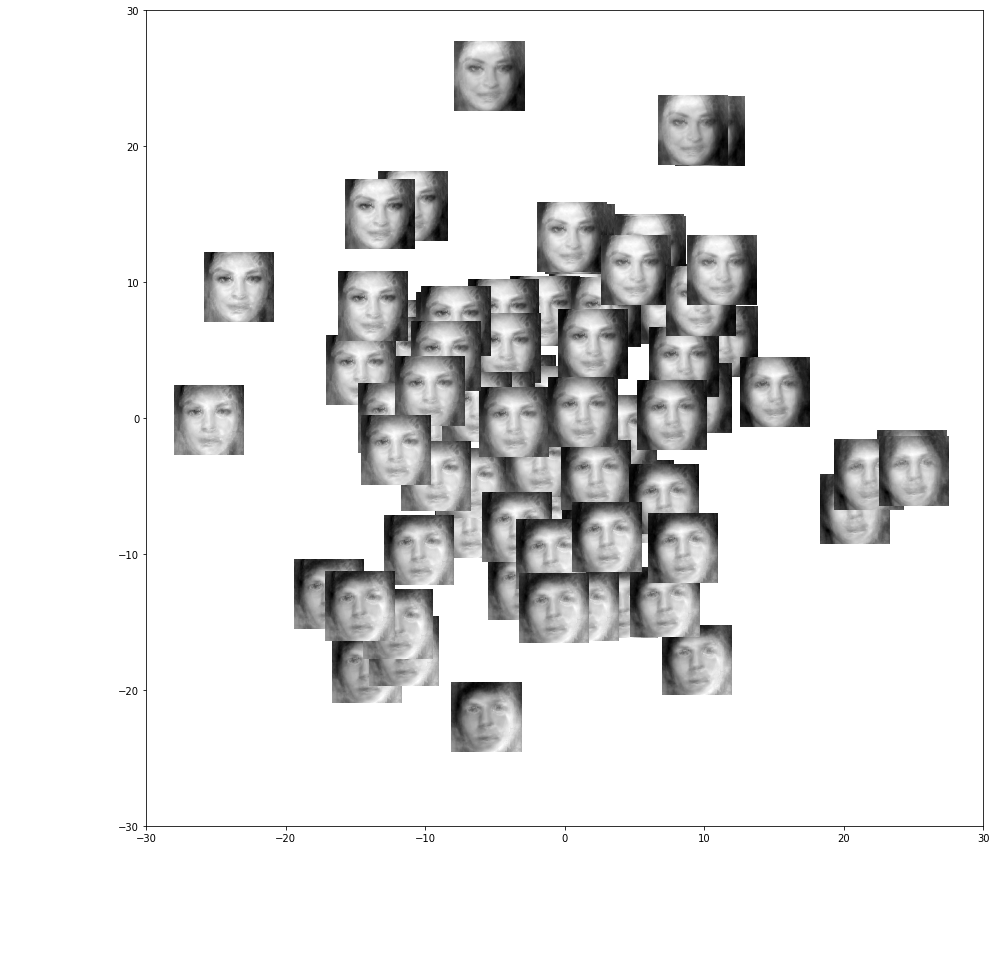

In [31]:
# VISUALIZE THE FACES ON THE FEATURE SPACE USING THE FIRST 2 PRINCIPAL COMPONENTS
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
for i in range(len(train_X)):
    #imgbox_image = OffsetImage(train_X[i], zoom=0.7)
    imgbox_image = OffsetImage(reconstructed_images[i], zoom=0.7)
    xy = [pca_df.at[i,'PC1'], pca_df.at[i,'PC2']]
    ab_image = AnnotationBbox(imgbox_image, xy, xybox=(0,0), boxcoords='offset points', frameon = False)
    ax.add_artist(ab_image)
plt.show()

From the previous space plots we can make the following conclusions:  
- PCA is not only a dimensionality reduction technique, it can also be considered as a unsupervised learning technique due to the clustering of the different samples. It can be observed that the green points (Mila Kunis) tend to be in the top of graph, whereas the yellow points (Jesse Eisenberg) are in the bottom. As we were expecting, the training data with label 0 was going to have similar values to Mila and Jesse.
- From the previous picture it can observed that with just 2 principal components it is not possible to recover the majority of the variance of the picutres. In the next cell it is showed that both components cover just 47% of the variance, when 95% it is considered to be good enough. At least, these components help to identify the sample it is either men or women. 

In [32]:
# EXPLAINED VARIANCE RATIO --> 2 COMPONENTS
print(pca_2.explained_variance_ratio)
print(np.cumsum(pca_2.explained_variance_ratio)[1])

[0.26185626 0.18999493]
0.4518511858846118


### 1.2.4. Discussion

In this section we will dicuss the next topics:
- 1. Optimal number *p* of principal components such that the dimensionality of the feature space is reduced but still informative through the analyis of the explained variance ratio. 
- 2. Projection of all images onto these optimal *p* components.
- 3. Visualize the reconstruction of one face using gradually more eigenfaces. 
- 4. Why using SVD instead of calculating eigenvalues of the covariance matrix. 

#### 1.2.4.1. Explained Variance Ratio (EVR) 
In the PCA the eigenvalues $\lambda_i$ can describe how much variance is associated with its associated eigenvector. This data is known as the explained variance ratio, and it can be computed as follows:

<p align="center">$\mathrm{EVR} = \dfrac{\dfrac{\lambda_i}{n-1}}{∑^n_{i=1}\dfrac{\lambda_i}{n-1}}$ </p>

Where $n$ is the number of samples (images) in the dataset. The [relationship between the singlular values](https://youtu.be/FgakZw6K1QQ?t=728) $\Sigma$, computed in the SVD, and the eigenvalues is: $\lambda_i = \Sigma^2_i$.   
The highest eigenvalue will indicate the highest variance in the data. If all the eigenvectors are taken into account, all the variance in the data sample can be represented. Instead of choosing arbitrarily the number of dimensions to reduce down, it is prefered to choose a number of dimensions that add up to a sufficiently large portion of the variance, for example 95%

In [33]:
# COMPUTE THE NECESSARY NUMBER OF COMPONENTS TO COVER 95% of the variance 
cumsum = np.cumsum(pca.explained_variance_ratio)
comp_95 = np.argmax(cumsum >= 0.95)
print (comp_95)

45


Text(0, 0.5, 'Explained variance')

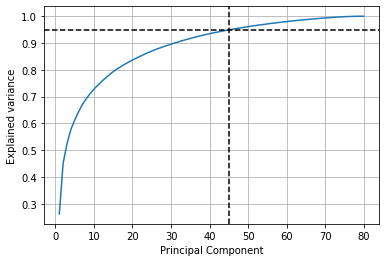

In [34]:
x_axis = np.arange(1, pca.n_components+1, 1)
plt.plot(x_axis, cumsum)
plt.grid()
plt.axvline(x = comp_95, color='k', linestyle='--')
plt.axhline(y = 0.95, color = 'k', linestyle = '--')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance')

In the previous graph it is observed that approximately 45 components are good enough to have an optimal reconstruction of each face. Now we will observe how the first 40 faces of the training set look after reducing the dimensionality of the pictures. 

#### 1.2.4.2. Projection over optimal hyperplane 
After executing the next code cell, it can be observed that the main features of all faces are recovered. For the human it is possible to identify who is who when the pictures were projected over the first 44 principal components, but could the classifier identify them? We will discover it in the next section...

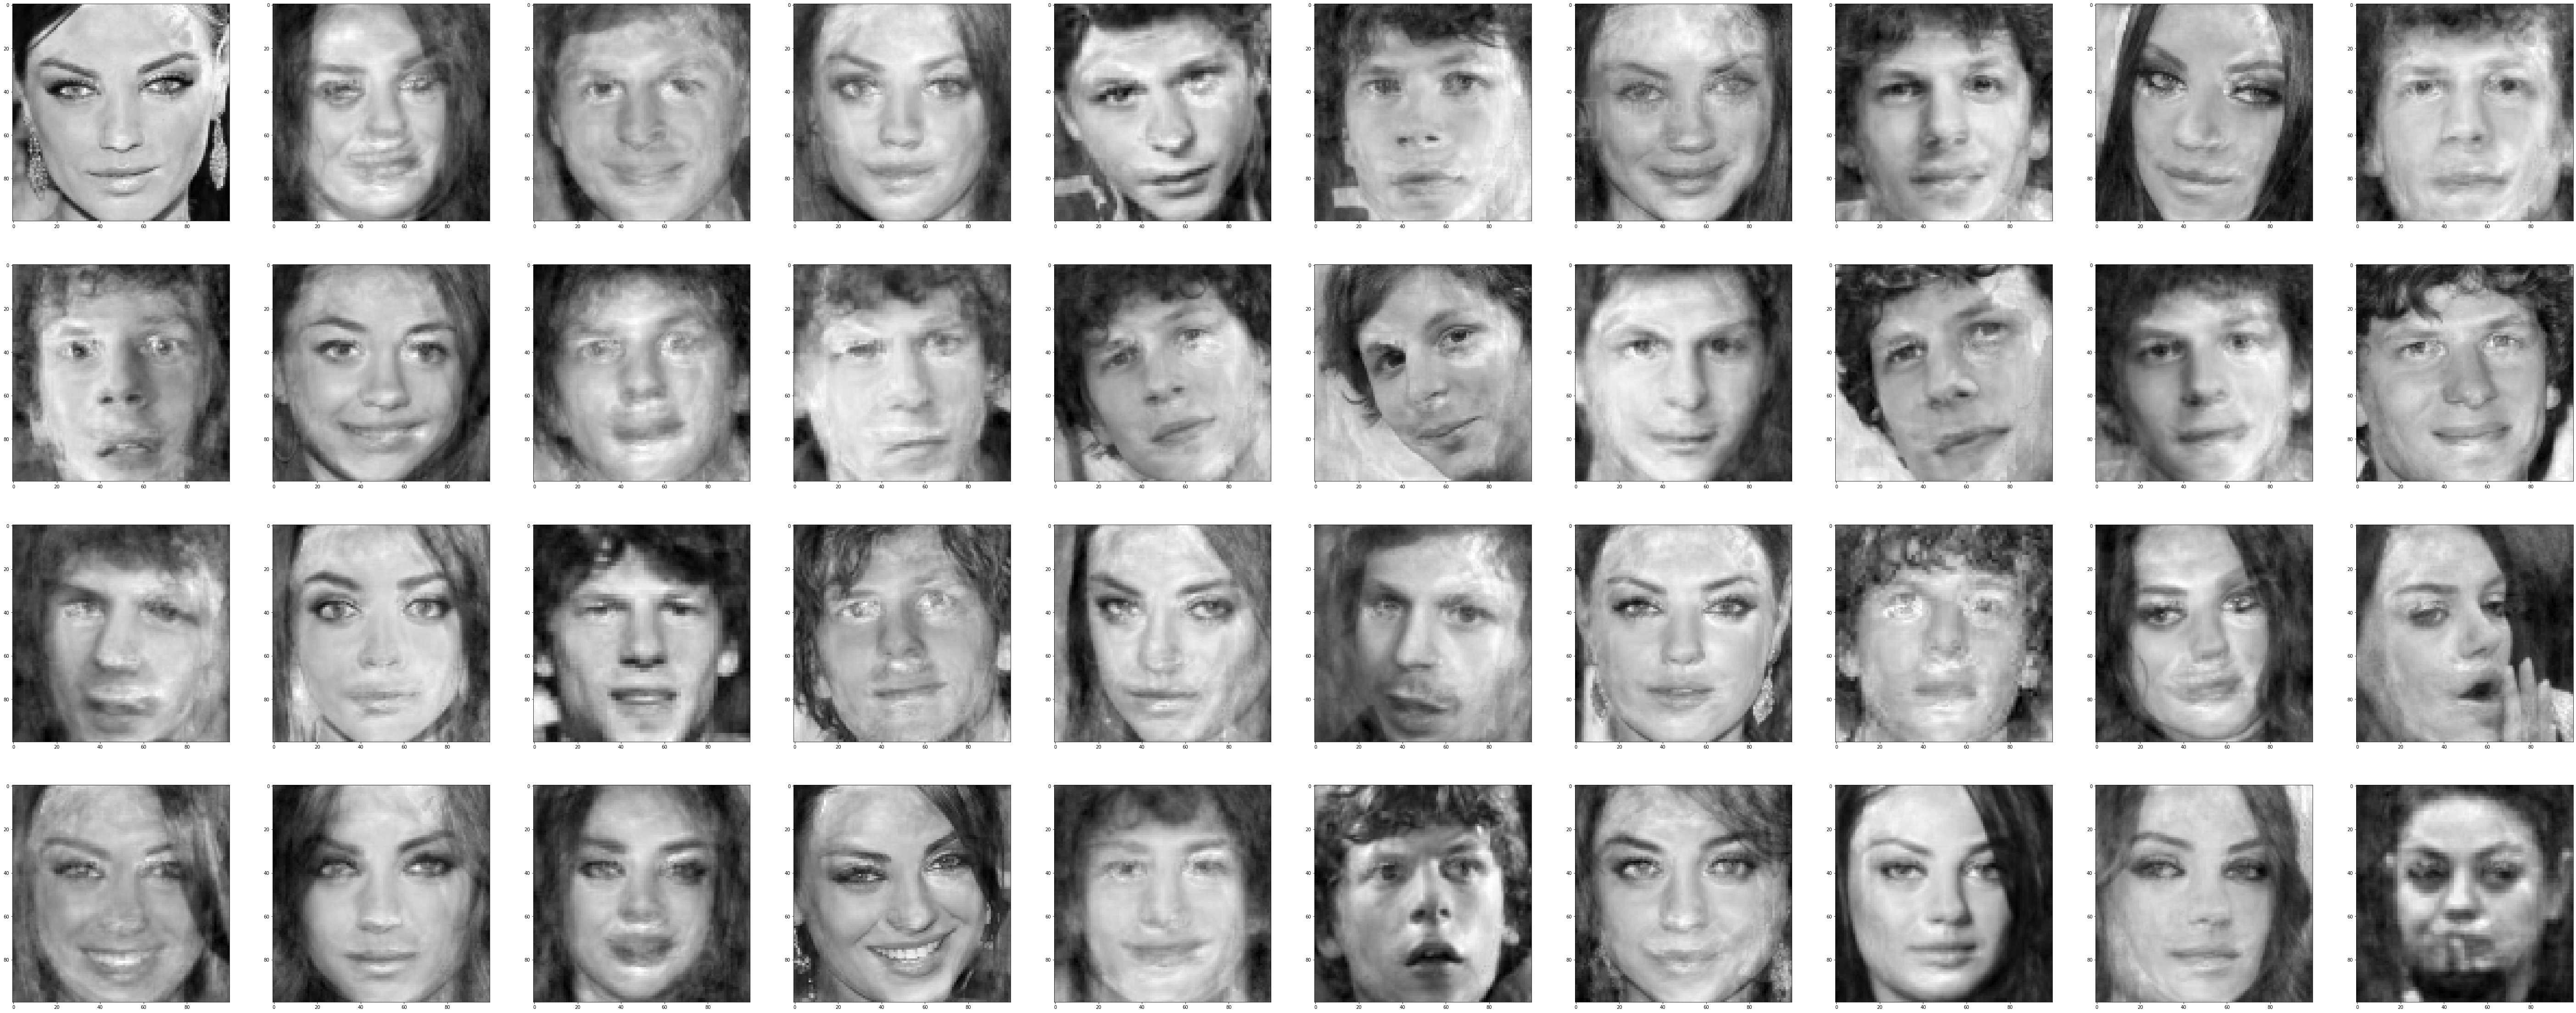

In [35]:
pca_95 = PCAFeatureExtractor(comp_95, FACE_SIZE)
pca_95.fit(train_X_flat);
X_projected95 = pca_95.transform(train_X_flat)
reconstructed_data95 = pca_95.inverse_transform(X_projected95)

reconstructed_images = [];
for i in range(train_X_flat.shape[0]):
    train_X95 = np.reshape(reconstructed_data95[i,:], FACE_SIZE)
    reconstructed_images.append(train_X95)
plot_image_sequence(reconstructed_images, n=40, imgs_per_row=10)


#### 1.2.4.3. Gradual reconstruction with more eigenfaces

In [36]:
# RECONSTRUCTION OF FACES
num_comp = [1,2,3,4,10,20,30,40,50,60,70,80]
reconstructed_images2 = [];

for p in num_comp:
    pca_grad = PCAFeatureExtractor(p, FACE_SIZE)
    pca_grad.fit(train_X_flat);
    projected = pca_grad.transform(train_X_flat)
    reconstructed = pca_grad.inverse_transform(projected)
    
    # Change the argument reconstructed [image] to check for a different image
    reconstructed_image = np.reshape(reconstructed[4],FACE_SIZE)
    reconstructed_images2.append(reconstructed_image)

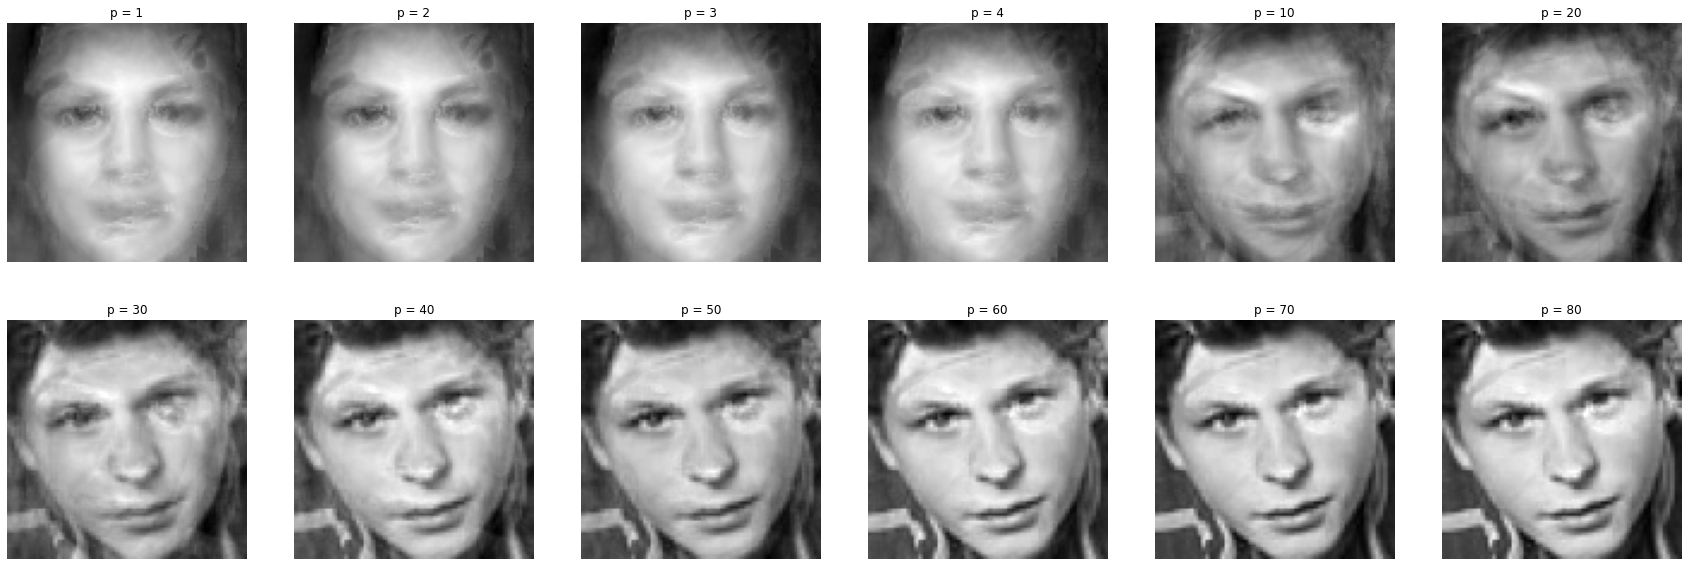

In [37]:
#plt.imshow(reconstructed_images[10], cmap=plt.cm.gray)
fig, axs = plt.subplots(2, 6, figsize=(30,10))
for i in range(len(num_comp)):
    if i<6:
        axs[0, i].imshow(reconstructed_images2[i])
        axs[0, i].set_title('p = '+ str(num_comp[i]))
        axs[0, i].axis('off')
    else:
        axs[1, i-6].imshow(reconstructed_images2[i])
        axs[1, i-6].set_title('p = '+ str(num_comp[i]))
        axs[1, i-6].axis('off')

#### 1.2.4.4. Singular Value Decomposition

The singular value decomposition is one of the most important matrix factorizations of the present time. It is a unique matrix decomposition that exists for every complex-valued matrix $\mathbf X$, defined as:  
<p align="center">$\mathbf {X = U\Sigma V^T}$ </p>

where $\mathbf U$ and $\mathbf V$ are invertible matrices with orthonormal columns, and $\mathbf \Sigma$ is a matrix with real, non-negative entries on the diagonal and zeros off the diagonal. The eigenvectors of the matrix $\mathbf X$ will be represented on each row of the matrix $\mathbf V$; moreover the diagonal elements of the matrix $\mathbf \Sigma$ are called **singular values**, and they are ordered from largest to smalles. These values have a mathematical relation with the eigenvalues of $\mathbf X$.

According to the PCA literature, the algorithm to perform this dimensionality reduction technique is as follows: compute the covariance matrix of the mean centered data, thereafter, calculate the eigenvectors and eigenvalues of the covariance matrix. So, <font size="4"> why use SVD on the mean-centerd data instead of calculating the covariance matrix? </font>

- The covariance matrix is defined as:  $\mathrm {C = X'\,X}$  
- The SVD method is defined as: $\mathrm {X = U \Sigma V'}$  

Then we can write a third equation using the definition of the previous both equations:  
$\mathrm {X'\,X = V \Sigma' U' U \Sigma V'}$.  
Because $\mathrm U$ is orthonormal the product $\mathrm {U'U = I}$  
Therefore $\mathrm {X'\,X = V D V'}$ where $\mathrm {D = \Sigma' \Sigma}$ which is a diagonal matrix with squares of the singular values. The square of a singular value is also known as **eigenvalue**. If we multiply both sides of the equation by $\mathrm {V}$ we would finish with the following equation:  
<p align="center">$\mathrm {(X'\,X)\, V = V D}$ </p>  

- The previous equation has the same form of the eigendecomposition equation $\mathrm {A v = v \lambda}$. 
- It is shown that SVD computes the eigenvectors and eigenvalues of the matrix $\mathrm {X}$, so we decided to use it because we save some steps: calculate the covariance matrix, calculate eigenvalues and eigenvectors, sort from highest to lowest the eigenvalues. 

More information on SVD:  
[1] [Steve Brunton - Singular Value Decomposition (SVD): Mathematica Overview](https://www.youtube.com/watch?v=nbBvuuNVfco)  
[2] [Herman Kamper - PCA Relationship to SVD](https://www.youtube.com/watch?v=DQ_BkPHIl-g)

# 2. Evaluation Metrics
## 2.0. Accuracy, Confusion Matrix and Precision
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages. For example we know that 37.5% pictures of the training set are pictures of Jesse Eisenberg, if the model always guess that an image is Non-Jesse, yout will be right 63% of the time, which is a relatively high score but not informative, for that we propose to use different metris.

The following metrics will be discussed just over the binary classifier of Jesse Eisenberg:  
**Confusion Matrix:** The general idea is to count the number of times that instances of class "Jesse" are classified as "Non-Jesse. Each row in a confusion matrix represents an actual class, while each column represents a predicted class. So, we will have a matrix size $2\times2$, where each element has the following definition:  
- Element (1,1) $\rightarrow$ *True negatives (TN)*: Non-Jesse image classified as Non-Jesse
- Element (1,2) $\rightarrow$ *False positives (FP)*: Non-Jesse image classified wrongly as Jesse
- Element (2,1) $\rightarrow$ *False negatives (FN)*: Jesse image classified wrongly as Non-Jesse
- Element (2,2) $\rightarrow$ *True positives (TP)*: Jesse image classified as Jesse
A perfect classifier would have only true positives and true negatives. Using those elements of the matrix, it is possible to compute a two more metrics: precision and recall.

**Precision:** The accuracy of the positives predictions $\frac{TP}{TP + FP}$  
**Recall:** The ratio of positive instances that are correctly detected. $\frac{TP}{TP+FN}$  
In the next section it will be possible to analyze the metrics obtained for different feature extractor methods using 2 Binary classifiers.

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

# 3. Classifiers
## 3.1.1 Neural Network Classifier

A brief introduction of Neural Networks is provided in order to have a general idea of this classifier. If you are interested on learning more about it, we highly suggest to consult one of the next sources:
- [Training Neural Networks I - Stanford University School of Engineering ](https://youtu.be/wEoyxE0GP2M)
- [Introduction to Deep Learning - MIT](http://introtodeeplearning.com/)  

First, let's discuss briefly the model created. 
- The first line creates a Sequential model. It is the simplest kind of Keras model, for neural networks that are just composed of a single stack of layers, connected sequentially. 
- A Flatten layer might be added if the input is provided in picture format --> (width x height). In our case the 3 feature extractors have already the output in 1D array form, so it is not necessary to add it. 
- The first Dense layer, indicate a hidden layer with 64 neurons. It will use the ReLU activation to add Non-linearities. 
- Finally we add a Dense output layer with 3 neurons (one per class: Mila, Jesse and Not them), using the softmax activation.

The Dense layers often have a lot of parameters. For example, the hidden layer has $N \times 64$ connection weights, where $N$ is the number of features, and it will depend on the feature extractor, plus 64 bias terms. For example, the HOG feature extractor has 648 features, which means that we have 41,536 parameters for the first hidden layer. This gives the model certain amount of flexibility to fit the training data, but it also means that the model has the risk of overfitting, especially when we don't have a lot of training data. 

After the model is created, the compile() method should be performed in order to specify the loss function and the optimizer to use.
ALGORITHM:
1. One sub-batch it is handled at a time (64), and it goes through the full training set multiple times (100), each pass is called an epoch. 
2. Mini batch $\rightarrow$ Input layer $\rightarrow$ Hidden layer
- The output of each neuron is computed, and passed to the next layer until reaching the last layer.
3. The network's output error is computed through the **Loss function** which compares the desired output and the actual output. 
4. A backpropagation algorithm is performed. It is checked how much of the error contributions come from each connection and here is were the **optimizer** plays an important role.

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 1: Deep Neural Network.</b></font> Our first iteration through classifiers was using a Neural Network as the one shown in the next cell. We assumed that it was our best option to get the better results. The results were not promising and here you can find our main conclusion. </div> 
- Artificial Neural Networks have several hyperparameters to define: Number of hidden layers and number of neurons per layer, optimizer, loss function, epochs, batch size, validation size. It brings difficulty to find the optimal parameters, even more when our training set is just 80 pictures and we are splitting 25% to validate the model. We decided to move on our efforts to a SVM or a Binary classifier. We got some insight on how to build a DNN through Keras, even for a Convolutioan Neural Network which will be useful for the last project. 

In [39]:
import tensorflow as tf
class NeuralNetwork:
    
    def fit(self, X, y):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation=tf.nn.relu),
            # tf.keras.layers.Dense(32, activation=tf.nn.relu),
            tf.keras.layers.Dense(3, activation=tf.nn.softmax)
        ])
            
        
        #Model Parameters
        self.model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2e-1),
                           loss="categorical_crossentropy", 
                           metrics=["accuracy"])
        self.Y_train = tf.keras.utils.to_categorical(y)
        
        #TRAIN
        self.model.fit(X, self.Y_train, epochs=50, batch_size=20, validation_split = 0.25)
        
        
    def predict(self, X):
        predict_y = self.model.predict(X) 
        return np.argmax(predict_y,axis=1)
    
    def __call__(self, X):
        return self.predict(X)

In [40]:
class ConvolutionalNeuralNetwork:
    def fit(self, X, y):
        self.cnn_model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            
            tf.keras.layers.Conv2D(filters=36, kernel_size=(3,3), activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation=tf.nn.relu),
            tf.keras.layers.Dense(3, activation=tf.nn.softmax)
        ])
        
        #MODEL PARAMETERS
        self.cnn_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
        self.Y_train = tf.keras.utils.to_categorical(y)
        
        #TRAIN
        self.cnn_model.fit(X, self.Y_train, epochs=20, batch_size=32)
        
    def predict(self, X):
        predict_y = self.model.predict(X) 
        return np.argmax(predict_y,axis=1)
    
    def __call__(self, X):
        return self.predict(X)

## 3.1.2 Binary Classifier
One of the main reasons to use a binary classifier was to compute the mean classification accuracy for Mila and Jesse, we will do it through the next metrics: Confusion Matrix, precision and recall. In general we are using 2 binary classifiers: a "Jesse-detector" and "Mila-detector". Each one will be distinguishing between just two classes: *to be or not to be* as Hamlet would say. 

### Stochastic Gradient Descent
Randomly selects N-samples and computes the lowest sum of squared residuals (Loss function) over it, in order to find the best fitting, therefore classify correctly our data. This randomly selection is suggested when the amount of data is large. If you want to know more about it we suggest to watch the following 2 videos:

- [Gradient Descent - StatQuest with Josh Starmer](https://youtu.be/sDv4f4s2SB8)
- [Stochastic Gradient Descent - StatQuest with Josh Starmer](https://www.youtube.com/watch?v=vMh0zPT0tLI)

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 2: Binary Classifier. </b></font> Our second iteration for classifiers was using two Binary classifiers. Using some metrics (over the same training data) would allow us to come to some conclusions about the different sections of the pipeline: which feature extractor had better results, find the optimal value for the random_state. A main insight was: either with the Histogram of Oriented Gradients or with Principal Component Analysis, the results of precision were below 0.70% for Mila and Jesse Eisenberg, so we started investing more time on the Face detector algorithm.  </div> 

- The binary classifier is not the best option for the present project. We compute first an algorithm to find the faces of Mila Kunis and then the ones of Jesse Eisenberg. Therefore, Michael Cera and Sarah Hyland pictures are not classified by the algorithm itself.

For example if there is a picture of the beautiful actress Gal Gadot, the algorithm will detect that she isn't either Mila or Jesse, and it will assign a label = 0 which is not quite informative because, indeed, she is not Sarah Hyland. 
If we really want to detect the faces of Michael Cera and Sarah Hyland, a third binary classifier should be computed, but we still need to use a fourth label to classify the faces that are not part of our 4 main actors of the project.

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

class BinaryClassificationModel:
    
    def fit(self, X, y):
        # BINARY CLASSIFIER FOR MILA KUNIS
        self.train_y2 = (y == 2)
        self.model2 = SGDClassifier(random_state=80)
        self.model2.fit(X,self.train_y2)
        self.trainY_pred2 = cross_val_predict(self.model2, X, self.train_y2, cv=3)
        self.confusionM2 = confusion_matrix(self.train_y2, self.trainY_pred2)
        self.precision2 = precision_score(self.train_y2, self.trainY_pred2)
        self.recall2 = recall_score(self.train_y2, self.trainY_pred2)
        
        # BINARY CLASSIFIER FOR JESSE EISENBERG
        self.train_y1 = (y == 1)
        self.model1 = SGDClassifier(random_state=65)
        self.model1.fit(X,self.train_y1)
        self.trainY_pred1 = cross_val_predict(self.model1, X, self.train_y1, cv=3)
        self.confusionM1 = confusion_matrix(self.train_y1, self.trainY_pred1)
        self.precision1 = precision_score(self.train_y1, self.trainY_pred1)
        self.recall1 = recall_score(self.train_y1, self.trainY_pred1)
        
        data = {'Name': ['Jesse Eisenberg', 'Mila Kunis'], 
                'Precision': [self.precision1, self.precision2],
                'Recall': [self.recall1, self.recall2]}    
        dframe = pd.DataFrame(data)  
        self.metrics = dframe
         
    def predict(self, X):
        binary_y = np.zeros(len(X)).astype(int)
        for i in range(len(X)):
            guess = self.model2.predict([X[i]])
            if guess:
                binary_y[i] = 2
        for i in range(len(X)):
            guess = self.model1.predict([X[i]])
            if guess:
                binary_y[i] = 1
        self.prediction = binary_y
        
        return self.prediction
    
    def __call__(self, X):
        return self.predict(X)

----------------


## 3.1.3 SVM Classifier

<div class="alert alert-block alert-info"> <font size="+1"><b>Iteration 3: Linear SVM. </b></font> The fundamental idea behind a Linear Support Vector Machines is to find a line that can separate the data in classes, in our case 3. We can think of an SVM as fitting the widest possible street between the classes, and the boundary decision of this street will be supported and fully determined bt the instances located closest to the line. These instances are called "Support Vectors". We used the scikit library to perform a linear SVM, and it worked surprisingly well, but we recognized that the data was not completly separable by a line. So we started exploring non-linear SVM. </div>


<div class="alert alert-block alert-info"> <font size="+1"><b> Iteration 4: Radial Basis Function SVM. </b></font> The last and the best iteration for our classifier was the Non-linear SVM. The optimal parameters C and $ \gamma $ were obtained exprimentally and consulting the scikit documentation. But also having the next information on mind: $\gamma$ acts like a regularization, if the model is overfitting, its value should be reduced, and if it is underfitting, it should be increased </div> 

You can consult the following links to get more information about it:
- [Scikit Learn: Support Vector Machines ](https://scikit-learn.org/stable/modules/svm.html)
- [SVM Kernels - In depth intuition](https://youtu.be/8bFKyb77vp0)

In [42]:
class SVMClassificationModel:
    
    def fit(self, X, y):
        # self.model = svm.SVC(kernel='linear', probability=True)
        self.model = svm.SVC(C=20, kernel = 'rbf',  gamma=0.1, probability=True)
        self.model.fit(X,y)
        
        
    def predict(self, X): 
        return self.model.predict(X)
    
    def __call__(self, X):
        return self.predict(X)

# 4. Experiments

## 4.0. Basic pipeline design
The basic pipeline defines first a feature extractor to be used and the classifier. Thereafter the training set is evaluated using the trained model in order to check for accuracy (which will not be a completely precise conclusion). Finally the test set is evaluated with the model previously trained, and the values are saved on the variable test_y_star, which later on can be saved as a .csv file.  
We decided to inspect 5% (90 samples) of the test dataset in order to bring different conclusions: We got an idea on how well is performing our classifier; we can observe the efectiveness of the Face detection algorithm. 

In [43]:
feature_extractor = HOGFeatureExtractor() 
classifier = SVMClassificationModel()
# Train the model on the features
classifier.fit(feature_extractor(train_X), train_y)
# Model/final pipeline
model = lambda X: classifier(feature_extractor(X))

In [44]:
# evaluate performance of the model on the training set
train_y_star = model(train_X)
"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
    accuracy_score(train_y, train_y_star))

'The performance on the training set is 1.00. This however, does not tell us much about the actual performance (generalisability).'

In [45]:
# Predict the labels for the test set 
test_y_star = model(test_X)

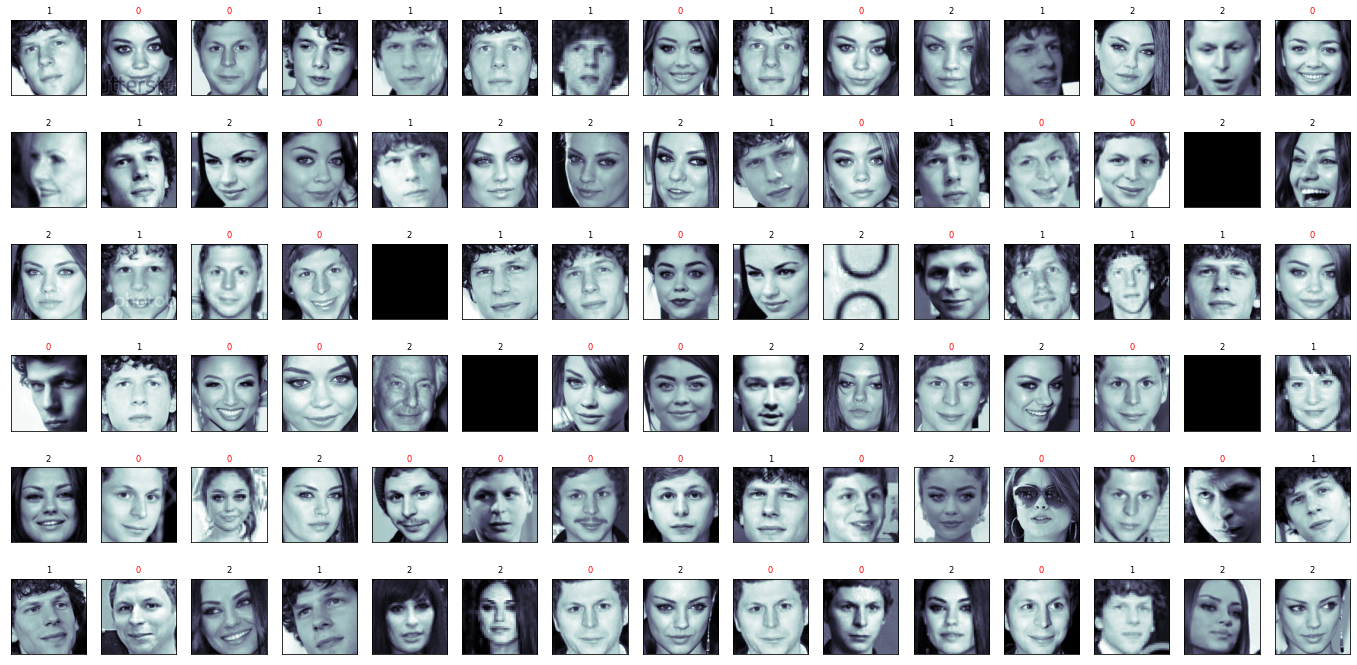

In [46]:
# INSPECTION OF 5% OF THE TEST DATA
fig = plt.figure(figsize=(24, 12))
for i in range(90):
    j = i + 0
    ax = fig.add_subplot(6, 15, i + 1, xticks=[], yticks=[])
    ax.imshow(test_X_flat[j].reshape((100,100)),
              cmap=plt.cm.bone)
    color = ('red' if  test_y_star[j]== 0 else 'black') #test_y_star[j]
    ax.set_title(test_y_star[j], fontsize='small', color=color)

## 4.1. Metrics Evaluation

In order to evaluate the features extractors built in section 4, we compute the precision and recall accuracy metrics following the next pipeline: The face extraction algorithm will be the same for all the experiments, HAAR Cascade detection. After that, on each experiment we will use a different face extractor. Finally the classifier in the experiments is selected to be the binary classifier. The metric that we will pay more attention will be precision. We encourage you to run the next 2 cells and observe the column of precision for each.<div class="alert alert-block alert-info"> <b>PIPELINE 1: Haar Face Detector - HOG Feature Extractor - Binary classifier </b>
</div>

In [47]:
# METRICS EVALUATION WITH HOG FEATURE EXTRACTOR 
feature_extractor = HOGFeatureExtractor() 
classifier = BinaryClassificationModel()

# Train the model on the features
classifier.fit(feature_extractor(train_X), train_y)

# Model/final pipeline
model = lambda X: classifier(feature_extractor(X))
train_y_star = model(train_X)
test_y_star = model(test_X)
classifier.metrics

Name  Precision    Recall
0  Jesse Eisenberg    0.90625  0.966667
1       Mila Kunis    0.75000  0.700000

<div class="alert alert-block alert-info"> <b>PIPELINE 2: Haar Face Detector - PCA Feature Extractor - Binary classifier </b>
</div>

In [48]:
# METRICS EVALUATION WITH PCA FEATURE EXTRACTOR 
feature_extractor = PCAFeatureExtractor(60, FACE_SIZE) 
classifier = BinaryClassificationModel()

# Train the model on the features
classifier.fit(feature_extractor(train_X_flat), train_y)

# Model/final pipeline
model = lambda X: classifier(feature_extractor(X))
train_y_star = model(train_X_flat)
test_y_star = model(test_X_flat)
classifier.metrics

Name  Precision    Recall
0  Jesse Eisenberg   0.805556  0.966667
1       Mila Kunis   0.634146  0.866667

These are the conclusions that we generate:  
1. **HOG Feature extractor** presents better results than **PCA** on precision category for both, Mila and Jesse. (Even using the sklearn decomposition.PCA method, HOG is still outperforming over PCA). Therefore in the next experiments we will be using HOG method as feature extractor in order to search for better results.
2. In both cases we see that Mila Kunis has a relative low precision value, this is because of some uncertainty on the pictures of Mila Kunis, there are some pictures that here face is not clear, another picture on which she is wearing big sunglasses that could represent wrong feature representation while extracting useful information. 

# 4.2 Conclave of methods

The idea behind this mechanic is to have a number of approaches to same problemathics and in the hope of achieving higher accuracy, we can let results of various approaches represent individual votes. Hopefully this will lead to better accuracy.

In [49]:
# mostly blind programming without really running it
"""def resolveVote(voting, voters):
    best = []
    searching_for = voting.sort()[-1]
    for i in range(len(voting)):
        if voting[i] == searching_for:
            best.append(i)
    return best[random.randint(len(best))]

test_y_star = []
classifiers = [ConvolutionalNeuralNetwork, BinaryClassificationModel, SVMClassificationModel]
for img in test_X:
    vote = [0]*3 # <- number of labels
    for classifier in classifiers:
        vote[model(np.array([img]))] += 1
    test_y_star.append(resolveVote)
    
test_y_star = np.array(test_y_star)
    """
    

'def resolveVote(voting, voters):\n    best = []\n    searching_for = voting.sort()[-1]\n    for i in range(len(voting)):\n        if voting[i] == searching_for:\n            best.append(i)\n    return best[random.randint(len(best))]\n\ntest_y_star = []\nclassifiers = [ConvolutionalNeuralNetwork, BinaryClassificationModel, SVMClassificationModel]\nfor img in test_X:\n    vote = [0]*3 # <- number of labels\n    for classifier in classifiers:\n        vote[model(np.array([img]))] += 1\n    test_y_star.append(resolveVote)\n    \ntest_y_star = np.array(test_y_star)\n    '

We tried to make the above code work, but were not able to do it in a timely manner.

# 5. Publishing best results
<div class="alert alert-block alert-info"> <b>PIPELINE 3: Haar Face Detector - HOG Feature Extractor - Support Vector Machine (RBF) </b>
</div>

In [50]:
feature_extractor = HOGFeatureExtractor() 
classifier = SVMClassificationModel()
# Train the model on the features
classifier.fit(feature_extractor(train_X), train_y)
# Model/final pipeline
model = lambda X: classifier(feature_extractor(X))

train_y_star = model(train_X)
test_y_star = model(test_X)

In [51]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star
submission

class
id         
0         1
1         0
2         0
3         1
4         1
...     ...
1811      0
1812      2
1813      1
1814      2
1815      0

[1816 rows x 1 columns]

In [52]:
submission.to_csv('submission.csv')

# 6. Discussion

## FACE EXTRACTOR - HAAR CASCADE
For a kid to learn what a square is, it is just necessary to point different objects with a square shape and say "square". Now the kid is able to recognize squares in all sorts of colors and sizes. For machine learning is not that straightforward. We discovered that are necessary "big-enough" training sets to make the classifier really learn as the kid would do.

According to Peter Norvig in his paper *"The unreasonable Effectiveness of Data"*, suggest that we may reconsider the time and money invested on algorithm development, when could be more important collecting more and better training data. And we agree on that, we are convinced that the performance of our classifier would have been better with a bigger training-set and having a better face-detector algorithm. For example, inspecting the 5% of the test-set, we discover that around 5 pictures have no face recognized, and the picture is interpreted as NAN (completely black).  
Some of those pictures have no information on it, so it is understandable getting the black picture, but others have faces that were not detected correctly, and they are still being classified as Mila-Kunis (label == 2), when it is not sure if Mila-Kunis is in the original picture. If we do the assumption that every 90 pictures there are 5 no-detected pictures, it brings a total of 100 which represents 6% of the total test-set. Hence, extracting correctly the face, would imply a potential correct classification and a increase on the final score. 

If we would have more time to spend on it, we would have tried a DNN module for face detection based on ResNet-10 architecture. It is a pretrained model, that has a much more robust algorithm to extract faces.

## PRINCIPAL COMPONENT ANALYSIS
PCA requires a lot of **preprocessing steps**: Matrix reshape, ensure that all images come in same size, mean centered data, normalization. After that complex mathematical operations are computed such as SVD. All of this could mean that there are potential loses of information while evaluating each of this steps. We have discovered that PCA is also sensitive to brightness and contrast of the pictures, so it would be much more useful when all the images are obtained in similar conditions (for example datasets available on sklearn library).  
The **optimal number of components** to consider is a crucial hyperparameter. One way to select it is covering 95% of the explained variance ratio, but when we applied inverse transform, it was concluded that for face detection it is also important small face details (such as scars or other face imperfections) that are only covered in the remaining eigenfaces. For shape detection, PCA could be quite useful, or also when the training set is much more bigger to make faster the model training and prediction, but for face detection is not the best option. 

A next step to apply on PCA that it would improve results, is to make the computation with the picture in color and not converting it to gray scale. It needs more coding time because instead of computing 1 mean, we need to calculate 3 means, one for each color channel, and the same for centering the data. Moreover, while computing the eigenvectors, several array operations should be performed to reshape correctly each eigenFace. Of course, the feature extractor would take more computing resources because now it deals with 30000 instead of 10000, but we ensure that while reducing the dimensionality less information is lost.

## DEEP NEURAL NETWORKS
In the beginning it seemed to be our best option to classify the pictures, but gradually we were discovering that it was maybe not the best one. First because a deep neural network gets so hungry of data, and our training set was not big enough to train the model and validate it. We tried using data augmentation techinques but probably our lack of experience on DNN didn't allow us to use them correctly, mainly for the difference between online and offline augmentation. We still believe it was a good approach, and if we would have a plenty of time, of course we would have explored even more on this technique.  
As it was mentioned before, we are aware that the final project of the Computer Vision course will imply the use of DNN, so we wanted to get familiar with the architecture and main concepts such as the hyperparameters. We are excited to learn more about it (:  

## INSIGHT AND LEARNING
- Kaggle: We got familiar with this web page which is widely known for its application on Machine Learning. It was the first time that the 3 of us used it, so it was nice to learn something new. Also the use of Jupyter Notebooks and explore another options as Google Colab.
- Feature extractors: SIFT and HOG. It was a good way to understand concepts that were not completely clear during the lectures, but through practice and applying it into a project was much better. 
- Dimensionality reduction: PCA. We knew that PCA is a technique commonly used to compress images, but now we know its applications also as a feature extractor and how to use the data on feeding machine learning algorithms. 
- Python libraries: We discovered the immense world of machine learning/Neural Networks that python has access. For this project was much more useful Scikit learn, but for the final project Tensorflow and Keras will be useful.